In [1]:
# pip install --upgrade pip

In [2]:
# pip install torchvision

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision 
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [4]:
device = torch.device('cuda:0'  if torch.cuda.is_available() else 'cpu' )

In [5]:
device, torch.__version__

(device(type='cpu'), '1.13.0+cpu')

In [6]:
# train = True --> default 
train_dataset =  torchvision.datasets.FashionMNIST(
    './fashionMnist/data', download=True,transform=transforms.Compose([ transforms.ToTensor() ])
    ,train = True
)

test_dataset =  torchvision.datasets.FashionMNIST(
    './fashionMnist/data', download=True,transform=transforms.Compose([ transforms.ToTensor() ])
    , train = False
)

In [7]:
# 데이터 셋으로부터 데이터 로드하기
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

In [8]:
for i in train_loader:
    a, b = i
    print(a.shape,len(b))
    break

torch.Size([100, 1, 28, 28]) 100


In [9]:
# 600번 순환
len(train_loader)

# train data total = 100*600 = 60000

600

In [10]:
len(test_loader)

100

In [11]:
temp1 = ['T-shirt/top'
,'Trouser'
,'Pullover'
,'Dress'
,'Coat'
,'Sandal'
,'Shirt'
,'Sneaker'
,'Bag'
,'Ankle boot'
]
temp2 = list(range(len(temp1)))
labelMap = dict(zip(temp2,temp1))

In [12]:
labelMap

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [13]:
len(train_dataset), np.random.randint(len(train_dataset))

(60000, 8444)

In [14]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

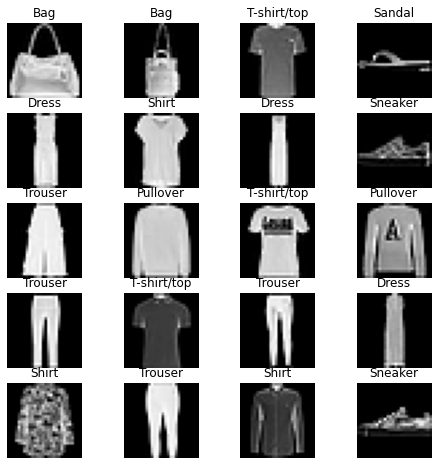

In [15]:
# 이미지 시각화
# ([0, 1, 28, 28],0)
fig = plt.figure(figsize=(8,8))
columns = 4;
rows = 5
for i in range(1, columns*rows+1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0,:,:]    # torch.Size([28, 28])
    fig.add_subplot(rows,columns,i)
    plt.title(labelMap[ train_dataset[img_xy][1] ])
    plt.axis('off')
    plt.imshow(img,cmap='gray')
plt.show()    

In [16]:
# ConvNet 미적용 신경망 설계
# F.relu() : forward에서 정의
# nn.Relu() : __init___에서 정의
class FashionDNN(nn.Module):
    def __init__(self):  # nn.OOO 는 init에서 설정
        super(FashionDNN,self).__init__()
        self.fc1 = nn.Linear(in_features=28*28,out_features=256)  # 입력층
        self.relu = nn.LeakyReLU()
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=256,out_features=128)  # hidden layer 1
        self.fc3 = nn.Linear(in_features=128,out_features=10)  # 출력층
        
    # override 된 함수로 반드시 forward 라고 해야 하며
    # FashionDNN 객체를  데이터와 함께 호출하면 forward 가 자동으로 실행  callback함수임
    def forward(self, input_data):  # 전방계산을 위한 연결  순전파학습
        # 최초 입력을 설계한 입력 shape에 맞게 resize
        out = input_data.view(-1,784)  # reshape와 동일
        out = self.fc1(out)
        out = self.relu(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out                

In [17]:
# 모델 객체
lr = 1e-3  # 0.001
model = FashionDNN()
model.to(device)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [18]:
# 손실함수 옵티마이저 
criterion = nn.CrossEntropyLoss()  #분류문제에서 사용
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [19]:
# 학습하기 위한 하이퍼 파라미터
num_epochs = 5
count = 0
loss_list, iteration_list,accuracy_list, prediction_list, labels_list = [],[],[],[],[]

In [20]:
# 학습
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # 모델이 데이터를 처리하기 위해 동일한 장치에 있어야 함
        # 자동 미분
        # Autograd : 자동미분의 값을 저장하기 위해서 tape를 사용
        # 순전파, 역전파
        
        train = Variable(images.view(100,1,28,28)) # 사이즈 조정(이미 되어 있어서 안해도 되지만 일관성을 위해서)
        labels = Variable(labels)
        outputs = model(train)  # 학습데이터 모델에 적용
        loss = criterion(outputs,labels)
        optimizer.zero_grad() # 기울기는 가중치와 달라서 업데이트 되면 안됨 그래서 매번 초기화 함
        loss.backward() # 오차를 각 가중치에 업데이트하는데. 기여한 만큼 한다.( 오차에 가중치미분값을 곱해서 나온값을 각 가중치에 빼준다)
        optimizer.step() # 옵티마이져를 업데이트(zero)
        count += 1
        
        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images,labels = images.to(device),labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100,1,28,28))
                outputs = model(test)
                predictions = torch.max(outputs,1)[1].to(device)
                prediction_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
            accuracy = correct*100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if not (count % 500):
            print(f"Iteration : {count}, Loss : {loss.data}, Accuracy : {accuracy}")

Iteration : 500, Loss : 0.5995174646377563, Accuracy : 83.44000244140625
Iteration : 1000, Loss : 0.5204088091850281, Accuracy : 84.44999694824219
Iteration : 1500, Loss : 0.3705734312534332, Accuracy : 84.83000183105469
Iteration : 2000, Loss : 0.39744091033935547, Accuracy : 86.31999969482422
Iteration : 2500, Loss : 0.2838771641254425, Accuracy : 85.69999694824219
Iteration : 3000, Loss : 0.303203284740448, Accuracy : 85.79000091552734


In [21]:
# 정확도를 가지고 측정할 때는 모든 클래스가 동등하게 고려된 것인지, 특정 클래스의 분류가 높았던 것인지 모름
# 데이터의 특성에 따른 정확도를 잘 관측해야 함

# 합성곱 신경망

In [22]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,padding=1) # [32,784,784]
            ,nn.BatchNorm2d(32)  # 학습과정에서 각 배치단위별로 데이터가 다양한 분포를 가지더라도 평균과 분산을 이용해서 정규화
            ,nn.LeakyReLU()
            ,nn.MaxPool2d(2,stride=2) # 32, 14, 14
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3)  # [64,12,12]
            ,nn.BatchNorm2d(64)  # 학습과정에서 각 배치단위별로 데이터가 다양한 분포를 가지더라도 평균과 분산을 이용해서 정규화
            ,nn.LeakyReLU()
            ,nn.MaxPool2d(2)  # 64, 6, 6
        )
        # Conv2d 에서 출력 크기 구하는 공식
        # 이미지 형태의 데이터를 배열 형태로 변환작업  (W-F+2P)/S+1
        # W : 입력데이터의 크기
        # F:커널 크기
        # P:패딩크기
        # S:스트라이드
        # (784-3+(2*0))/1+1 = 784  -> [32,784,784]
        
        # MaxPool2d에서 출력 크기 구하는 공식
        # IF/F
        # IF : 입력필터의 크기 또는 바로 앞의 Conv2d의 출력크기
        # F : 커널 크기
        # 784 / 2 = 392
        #[32,392,392]       
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        # print(out.shape)
        out = self.layer2(out)
        # print(out.shape)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.drop(out)        
        out = self.fc2(out)
        out = self.fc3(out)
        return out        

In [23]:
learning_rate = 0.001
model = FashionCNN()
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [24]:
# 학습
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # 모델이 데이터를 처리하기 위해 동일한 장치에 있어야 함
        # 자동미분
        # Autograd : 자동미분의 값을 저장하기위해서 tape를 사용
        # 순전파, 역전파
        train = Variable(images.view(100,1,28,28)) # 사이즈 조정(이미 되어 있어서 안해도 되지만... 일관성을 위해서)
        # print(f"train : {train.shape}")
        labels = Variable(labels)
        outputs = model(train)  # 학습데이터 모델에 적용
        loss = criterion(outputs,labels)
        optimizer.zero_grad() # 기울기는 가중치와 달라서 업데이트 되면 안됨 그래서 매번 초기화 함
        loss.backward() # 오차를 각 가중치에 업데이트하는데. 기여한 만큼 한다.( 오차에 가중치미분값을 곱해서 나온값을 각 가중치에 빼준다)
        optimizer.step() # 옵티마이져를 업데이트(zero)
        count += 1
        
        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images,labels = images.to(device),labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100,1,28,28))
                outputs = model(test)
                predictions = torch.max(outputs,1)[1].to(device)
                prediction_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
            accuracy = correct*100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if not (count % 500):
            print(f"Iteration : {count}, Loss : {loss.data}, Accuracy : {accuracy}")

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration : 3500, Loss : 0.42398810386657715, Accuracy : 88.08999633789062
Iteration : 4000, Loss : 0.3498876988887787, Accuracy : 88.7300033569336
Iteration : 4500, Loss : 0.3130861520767212, Accuracy : 86.87999725341797
Iteration : 5000, Loss : 0.20793546736240387, Accuracy : 89.45999908447266
Iteration : 5500, Loss : 0.10889916121959686, Accuracy : 89.68000030517578
Iteration : 6000, Loss : 0.1573794186115265, Accuracy : 90.69999694824219


# 전이학습

In [25]:
# ImageNet : 이미지로 이루어진 데이터 셋 >>  ImageNet을 써서 훈련된 모델의 가중치를 가져와 우리가 해결하려는 과제에 맞게 보정해서 사용
# 아주 큰 데이터셋을 사용해서 훈련된 모델을 사전훈련된 모델(네트웍)이라고 함

# 특성추출 기법
- ImageNet 데이터셋으로 사전 훈련된 모델을 가져온 후 마지막에 완전 연결층 부분만 새로 만듦
- 특성 추출은 두 부분으로 구성
- 합성곱층 : Convolution
- 데이터 분류기(완전연결층)
- 합성곱층(가중치 고정)에 새로운 데이터를 통과 >> 그 출력을 데이터 분류기에서 훈련시킴

In [26]:
'''
XCeption
Inception V3
ResNet50
VGG16
VGG19
MobileNet
'''

'\nXCeption\nInception V3\nResNet50\nVGG16\nVGG19\nMobileNet\n'

In [27]:
# 필요 라이브러리 설치

!pip install opencv-python

In [28]:
import os
import time
import copy
import glob
import cv2
import shutil
import torch
import torchvision # 컴퓨터 비전
import torchvision.transforms as transforms # 데이터 전처리
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [29]:
data_path = './data/catanddog/train'

In [30]:
transform = transforms.Compose(
    [transforms.Resize([256,256]), # 크기조정
     transforms.RandomResizedCrop(224), # 이미지를 랜덤한 크기 및 비율로 자름, 데이터 확장용도로 사용.
                                        # 즉, 데이터를 랜덤한 비율로 잘라서 크기를 조정
     transforms.RandomHorizontalFlip(), # 수평으로 뒤집음
     transforms.ToTensor()  # 텐서로 변경
    ])
train_dataset = torchvision.datasets.ImageFolder(data_path, transform=transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 32,
    num_workers = 6,
    shuffle = True)
print(len(train_dataset))

385


In [31]:
# 개 고양이 데이터는 캐글에 잇는데 여기서는 385개만 사용

In [32]:
# RandomResizedCrop 사용하기 위해서 mxnet를 설치
!pip install --user mxnet

  Using cached numpy-1.16.6-cp39-cp39-win_amd64.whl
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'C:\\Users\\user\\AppData\\Roaming\\Python\\Python39\\site-packages\\~umpy\\.libs\\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll'
Check the permissions.



In [33]:
import mxnet as mx
from mxnet.gluon.data.vision import transforms

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


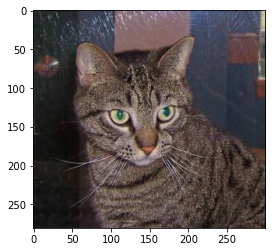

In [34]:
sample_image = mx.image.imread('./data/catanddog/train/Cat/1.jpg')
plt.imshow(sample_image.asnumpy())

In [35]:
# RandomResizedCrop 적용 함수
def show_images(imgs, num_rows, num_cols, scale = 2):
    aspect_ratio = imgs[0].shape[0] / imgs[0].shape[1] # 확장할 이미지의 크기 조정
    figsize = (num_cols*scale, num_rows*scale*aspect_ratio)
    _,axes = plt.subplots(num_rows,num_cols,figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i*num_cols + j].asnumpy())
            axes[i][j].axes.get_xaxis().set_visible(False) # x축 전체를 숨김            
            axes[i][j].axes.get_yaxis().set_visible(False) # y축 전체를 숨김
    plt.subplots_adjust(hspace=0.1, wspace=0)
    return axes

In [36]:
def apply(img,aug,num_rows=2, num_cols=4, scale=3):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y,num_rows, num_cols, scale)

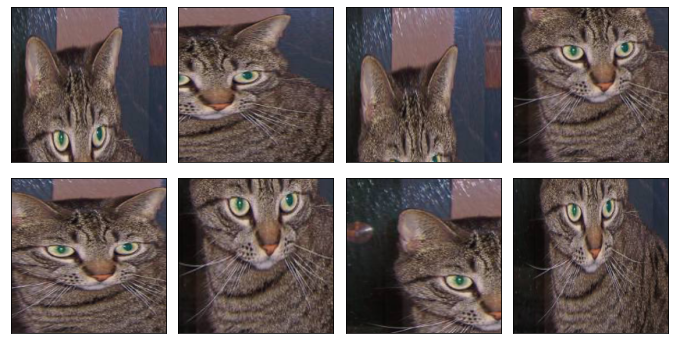

In [37]:
shape_aug = transforms.RandomResizedCrop(
    size = (200,200),  # 출력 비율을 200 * 200
    scale = (0.1,1),   # 면적 비율은 0.1 ~ 1  >> (10% ~ 100%) 범위 내에서 무작위로 자름
    ratio = (0.5,2)    # 면적의 너비와 높이 비율을 0.5 ~ 2 범위 내에서 무작위로 조절
)
apply(sample_image, shape_aug)

In [38]:
# 학습에 사용할 데이터 확인 24개
temp = iter(train_loader)
samples,labels = next(temp)

In [39]:
labels[0].item()

1

In [40]:
samples[0].numpy().shape, samples[0].numpy().T.shape

((3, 224, 224), (224, 224, 3))

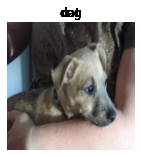

In [41]:
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize = (16,24))
for i in range(1,25):
    ax = fig.add_subplot(4,6,1)
    ax.set_title(classes[labels[i].item()])
    ax.axis('off')
    ax.imshow(np.transpose(samples[i].numpy(), (1,2,0) ))
plt.subplots_adjust(bottom=0.2, top = 0.6, hspace = 0)

In [42]:
# # 사전훈련된 모델 받기
# resnet18 = models.resnet18(weights = True) # 사전에 학습된 가중치를 사용
# # 50 개의 층으로 이루어진 함성곱 신경망
# alexnet = models.alexnet(weights = True)
# squeezenet1_0 = models.squeezenet1_0(weights = True)
# vgg16 = models.vgg16(weights = True)
# densenet161 = models.densenet161(weights = True)
# inception_v3 = models.inception_v3(weights = True)
# googlenet = models.googlenet(weights = True)
# shufflenet_v2_x1_0 = models.shufflenet_v2_x1_0(weights = True)
# mobilenet_v2 = models.mobilenet_v2 (weights = True)
# mobilenet_v3_large = models.mobilenet_v3_large(weights = True)
# mobilenet_v3_small = models.mobilenet_v3_small(weights = True)
# resnext50_32x4d = models.resnext50_32x4d(weights = True)
# wide_resnet50_2 = models.wide_resnet50_2(weights = True)
# mnasnet1_0 = models.mnasnet1_0(weights = True)